[Multivariate quantiles and long horizon forecasting with N-HiTS](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/nhits.html)
----



In [1]:
!pip install -r ./requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://github.com/KelvinKan/CP-Flow.git (to revision package-specific-version) to /private/var/folders/zb/tts3v_1n6_q7k08zvlx60d5m0000gn/T/pip-req-build-milm8yd8
  Running command git clone --filter=blob:none --quiet https://github.com/KelvinKan/CP-Flow.git /private/var/folders/zb/tts3v_1n6_q7k08zvlx60d5m0000gn/T/pip-req-build-milm8yd8
  Running command git checkout -b package-specific-version --track origin/package-specific-version
  Switched to a new branch 'package-specific-version'
  Branch 'package-specific-version' set up to track remote branch 'package-specific-version' from 'origin'.
  Resolved https://github.com/KelvinKan/CP-Flow.git to commit 02eb8f7243cafb8cf655dfd05c0ee32ccdd32248
  Preparing metadata (setup

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MQF2DistributionLoss, QuantileLoss

In [4]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [5]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

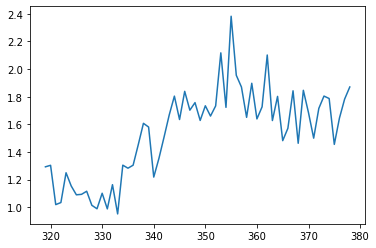

In [6]:
data.loc[data['series']==0]['value'].iloc[-max_encoder_length+training_cutoff:training_cutoff].plot();

In [7]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5462)

In [8]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=torch.cuda.device_count(), gradient_clip_val=1.0)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/jimako/ghq/github.com/tk42/nhits-trial/.lr_find_c9054215-dd7c-4b16-823c-227295b2b656.ckpt


suggested learning rate: 0.17782794100389224


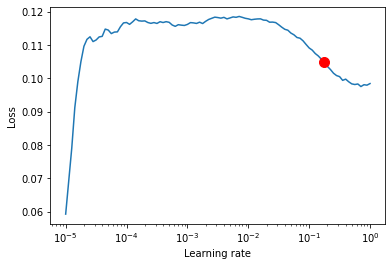

In [9]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [10]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=0.09,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 5.1 K 
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 35.7 K
---------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [12]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.2021)

In [13]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

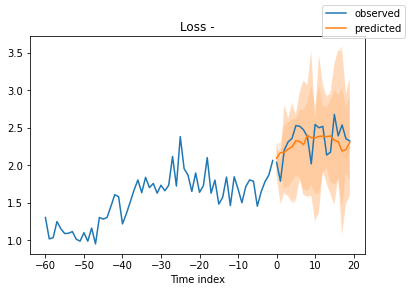

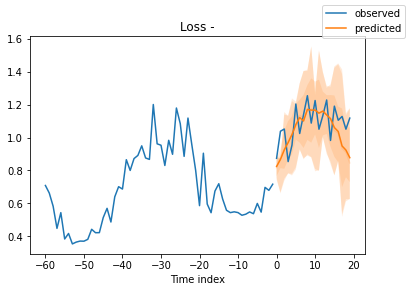

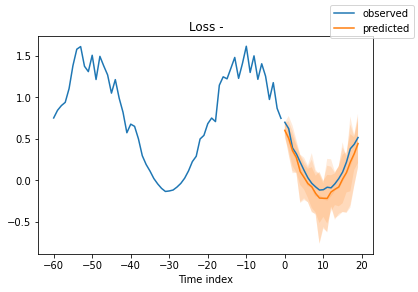

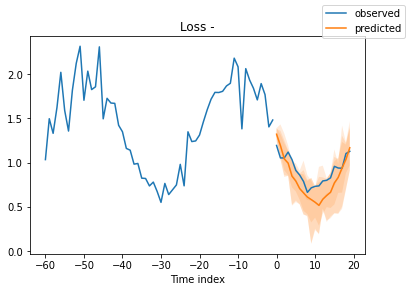

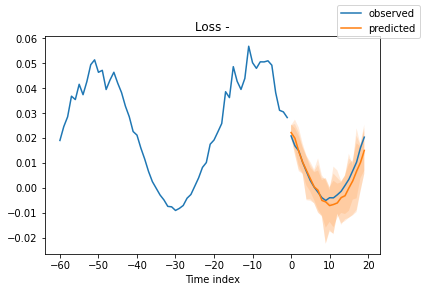

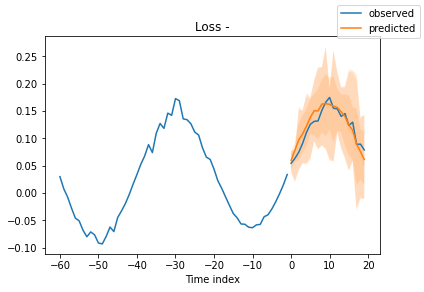

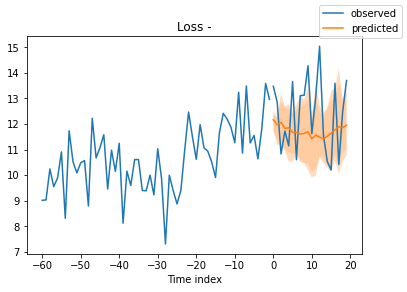

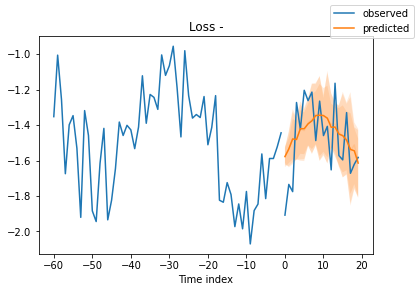

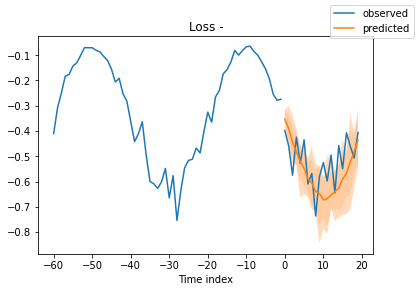

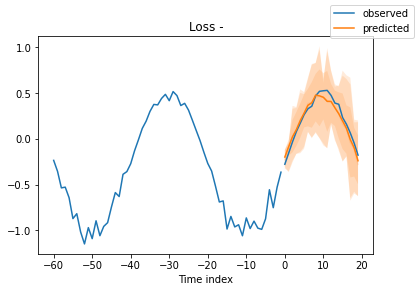

In [14]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

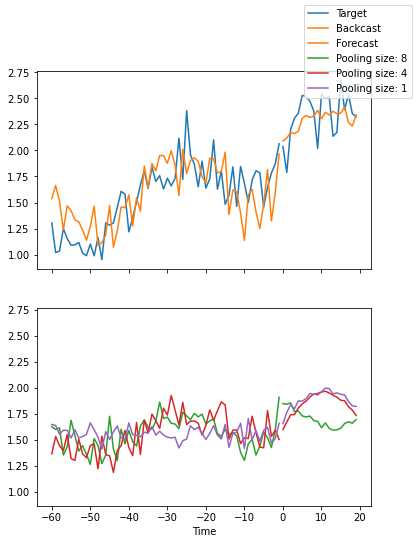

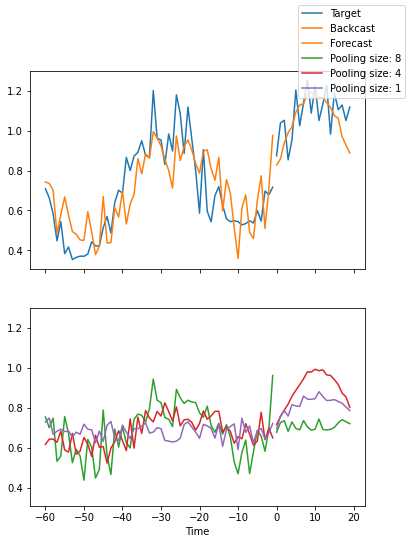

In [15]:
for idx in range(2):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);

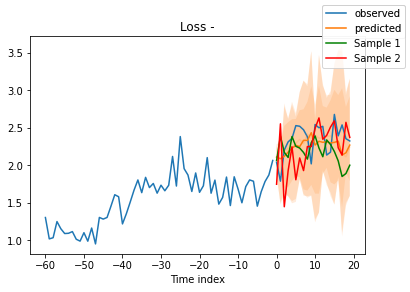

In [16]:
# sample 500 paths
samples = best_model.loss.sample(raw_predictions["prediction"][[0]], n_samples=500)[0]

# plot prediction
fig = best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
ax = fig.get_axes()[0]
# plot first two sampled paths
ax.plot(samples[:, 0], color="g", label="Sample 1")
ax.plot(samples[:, 1], color="r", label="Sample 2")
fig.legend();

In [17]:
print(f"Var(all samples) = {samples.var():.4f}")
print(f"Mean(Var(sample)) = {samples.var(0).mean():.4f}")

Var(all samples) = 0.0856
Mean(Var(sample)) = 0.0595


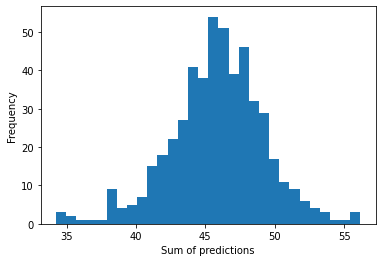

In [18]:
plt.hist(samples.sum(0).numpy(), bins=30)
plt.xlabel("Sum of predictions")
plt.ylabel("Frequency");